In [1]:
import sys
import escher
import cobra
import cobra.exceptions
import numpy as np
from cobra.io import read_sbml_model
import matplotlib.pyplot as plt
import scipy.stats
from scipy.io.matlab import loadmat
import pandas as pd
from optslope import calculate_slope

exp_metadata = pd.DataFrame.from_dict([
    {"index": 0, "label": "Strain E1: succinate", "color": "#66a488", "marker": "s"},
    {"index": 1, "label": "Strain E2: succinate+glycerol", "color": "#bcbec0", "marker": "s"},
    {"index": 2, "label": "Strain E3*: succinate+glycerol+glycine", "color": "#4991c9", "marker": "s"},
    {"index": 3, "label": "Strain P1: (no other carbon source)", "color": "#cc9f68", "marker": "o"},
    {"index": 4, "label": "Strain P1: succinate", "color": "#cc9f68", "marker": "s"},
    {"index": 5, "label": "Strain P2: glycerol", "color": "#d87881", "marker": "o"},
    {"index": 6, "label": "Strain P2: succinate+glycerol", "color": "#d87881", "marker": "s"},
    {"index": 7, "label": "Strain P3: glycerol+glycine", "color": "#a381bd", "marker": "o"},
    {"index": 8, "label": "Strain P3: succinate+glycerol+glycine", "color": "#a381bd", "marker": "s"},
]).set_index("index")

exp_data = loadmat("DATAX6.mat")
exp_ods = exp_data["OD"]
exp_ods[np.isnan(exp_ods)] = -1 # replace NaN with -1 for easy calculations
exp_conc = exp_data["CONC"].squeeze()

MODEL_FNAME = "core_model_extended.xml"

target_reaction = 'glycerate_t'

model_data = pd.DataFrame.from_dict([
    {"knockouts": ["ENO"], "carbon_sources": ("glycerate", "succinate"), "metadata_index": 0},
    {"knockouts": ["PGK", "ENO"], "carbon_sources": ("glycerate", "succinate", "glycerol"), "metadata_index": 1},
    {"knockouts": ["PGK", "ENO", "glyA"], "carbon_sources": ("glycerate", "glycerol" , "succinate", "glycine"), "metadata_index": 2},
    {"knockouts": ["PPS", "PPCK"], "carbon_sources": ("glycerate", ), "metadata_index": 3},
    {"knockouts": ["PPS", "PPCK"], "carbon_sources": ("glycerate", "succinate"), "metadata_index": 4},
    {"knockouts": ["PGK", "PPS", "PPCK"], "carbon_sources": ("glycerate", "glycerol"), "metadata_index": 5},
    {"knockouts": ["PGK", "PPS", "PPCK"], "carbon_sources": ("glycerate", "succinate", "glycerol"), "metadata_index": 6},
    {"knockouts": ["PGK", "PPS", "PPCK", "glyA"], "carbon_sources": ("glycerate", "glycerol", "glycine"), "metadata_index": 7},
    {"knockouts": ["PGK", "PPS", "PPCK", "glyA"], "carbon_sources": ("glycerate", "succinate", "glycerol", "glycine"), "metadata_index": 8},
    {"knockouts": ["PGK", "PPS", "PPCK", "G6PDH2r"], "carbon_sources": ("glycerate", "glycerol"), "metadata_index": 5},
    {"knockouts": ["PGK", "PPS", "PPCK", "glyA", "G6PDH2r"], "carbon_sources": ("glycerate", "glycerol", "glycine"), "metadata_index": 7},
])

In [2]:
def find_offset(x, y, window_size=5):
    """Finds the window with the best fit for the line with slope = 1 (in terms of MSE)."""
    
    offset_list = []
    mse_list = []
    for i in range(len(x) - window_size):
        x_win = x[i:i+window_size]
        y_win = y[i:i+window_size]
        offset = np.mean(x_win) - np.mean(y_win)
        offset_list.append(offset)
        #print(x_win, y_win)
        mse = np.mean( (x_win - y_win - offset)** 2) 
        mse_list.append(mse)
    
    mses = np.array(mse_list)
    offsets = np.array(offset_list)
    #print(mses.round(2), np.exp(offsets).round(2))
    return offsets[mses.argmin()]

In [3]:
ods = exp_ods[:, 4]
mask = (0.0 < ods)
ods = ods[mask]
conc = exp_conc[mask]
godr = np.exp(find_offset(np.log(conc), np.log(ods)))

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ymin = 2e-2
ymax = 2
# filter all OD measurements under 1, and perform linear regression to find the GODR values (in mM per OD)
exp_metadata["GODR"] = np.nan
for row in exp_metadata.itertuples():
    ods = exp_ods[:, row.Index]
    mask = (0.0 < ods)
    ods = ods[mask]
    conc = exp_conc[mask]
    
    # ignore cases where the minimal OD is more than 0.1
    if min(ods) < 0.1:
        godr = np.exp(find_offset(np.log(conc), np.log(ods)))
        ax.plot([ymin*godr, ymax*godr],
                [ymin, ymax],
                '-',
                color=row.color,
                alpha=1)
        new_label = row.label + f" ({godr:.2f})"
        exp_metadata.at[row.Index, 'GODR'] = godr
    else:
        new_label = row.label + " (NA)"
    ax.plot(exp_conc, exp_ods[:, row.Index], marker=row.marker,
            label=new_label, color=row.color, linewidth=0, zorder=5)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("Concentration of glycerate (mM)")
ax.set_ylabel("Maximum OD$_{600}$")
ax.grid(True, "both", "both", alpha=0.2)
ax.set_ylim(ymin, ymax)
#ax.set_title("calculating the GODR values")
ax.plot([0.04, 0.04], [ymin, ymax], 'k--', linewidth=0.8, zorder=0)
ax.plot([2.7, 2.7], [ymin, ymax], 'k--', linewidth=0.8, zorder=0)

ax.legend(bbox_to_anchor=(1, 1))
fig.tight_layout()
fig.savefig("fig9.svg")

In [7]:
model_data["GBR"] = np.nan
for row in model_data.itertuples():
    gbr = calculate_slope(read_sbml_model(MODEL_FNAME),
                          knockouts=row.knockouts,
                          carbon_sources=row.carbon_sources,
                          target_reaction=target_reaction)
    model_data.at[row.Index, "GBR"] = gbr

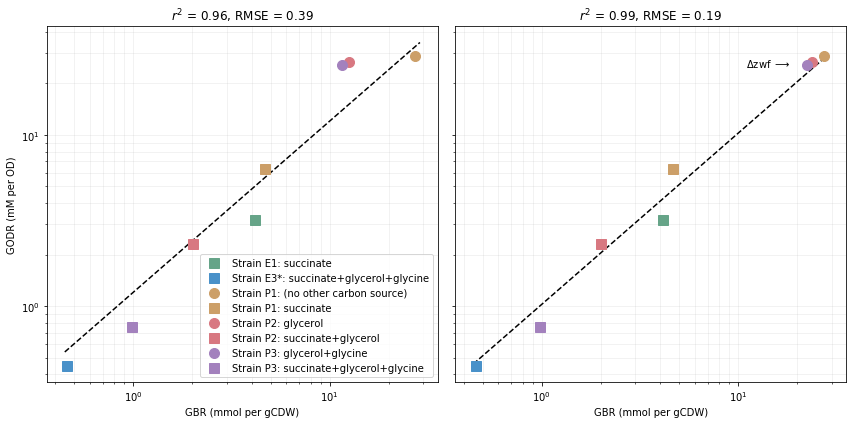

In [8]:
joined_df = model_data.join(exp_metadata, on="metadata_index")
joined_df1 = joined_df.loc[[0, 2, 3, 4, 5, 6, 7, 8], :]
joined_df2 = joined_df.loc[[0, 2, 3, 4, 9, 6, 10, 8], :] # here we replace P2:glycerol and P3:glycerol+glycine with versions where ZWF is knocked out

fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
for df, ax in zip([joined_df1, joined_df2], axs.flat):
    log_xvalues = np.log(df.GBR)
    log_yvalues = np.log(df.GODR)
        
    r_squared = scipy.stats.linregress(log_xvalues, log_yvalues).rvalue**2
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid(True, which='both', axis='both', alpha=0.2)
    ax.set_xlabel("GBR (mmol per gCDW)")

    # draw the line of best fit (for all lines with slope = 1, in logscale)
    offset = np.exp(np.mean(log_yvalues) - np.mean(log_xvalues))
    vmin = min(min(df.GBR), min(df.GODR))
    vmax = max(max(df.GBR), max(df.GODR))
    ax.plot([vmin, vmax], [vmin*offset, vmax*offset], 'k--')

    RMSE = np.sqrt(np.mean( (log_xvalues - log_yvalues + np.log(offset))** 2) )
    ax.set_title(f"$r^2$ = {r_squared:.2f}, RMSE = {RMSE:.2f}")
    
    for row in df.itertuples():
        ax.plot(row.GBR, row.GODR, marker=row.marker, linewidth=0, ms=10,
                label=row.label, color=row.color)
axs[0].legend(loc="lower right")
axs[0].set_ylabel("GODR (mM per OD)")
axs[1].text(11, 25, r"$\Delta$zwf $\longrightarrow$")
fig.tight_layout()
fig.savefig("fig10.svg")